# Importando as bibliotecas necessárias

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os
from graphviz import Digraph
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

# Configurações globais

In [15]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-pastel")
sb.set_palette("pastel")
pd.set_option("display.max_columns", None)

DATA_PATH = "../data/"
RESULTS_PATH = "../results/"

# Função para carregar e tratar os dados

In [16]:
if "files" not in globals():
    files = {
        'customers': 'olist_customers_dataset.csv',
        'geolocation': 'olist_geolocation_dataset.csv',
        'order': 'olist_order_items_dataset.csv',
        'payments': 'olist_order_payments_dataset.csv',
        'reviews': 'olist_order_reviews_dataset.csv',
        'orders': 'olist_orders_dataset.csv',
        'products': 'olist_products_dataset.csv',
        'sellers': 'olist_sellers_dataset.csv',
        'category': 'product_category_name_translation.csv'
    }

if "dfs" not in globals():
    dfs = {}
    for name, file in files.items():
        dfs[name] = pd.read_csv(os.path.join(DATA_PATH, file))

for name, df in dfs.items():
    before = df.shape[0]
    df.drop_duplicates(inplace=True)
    after = df.shape[0]
    print(f"{name}: {before - after} duplicatas removidas.")

dfs["orders"].dropna(subset=["order_purchase_timestamp", "order_delivered_customer_date", "order_estimated_delivery_date"], inplace=True)

if "freight_value" in dfs["order"].columns:
    dfs["order"]["freight_value"].fillna(0, inplace=True)

for name, df in dfs.items():
    print(f"\nValores nulos em {name}:")
    print(df.isnull().sum())

customers: 0 duplicatas removidas.
geolocation: 0 duplicatas removidas.
order: 0 duplicatas removidas.
payments: 0 duplicatas removidas.
reviews: 0 duplicatas removidas.
orders: 0 duplicatas removidas.
products: 0 duplicatas removidas.
sellers: 0 duplicatas removidas.
category: 0 duplicatas removidas.

Valores nulos em customers:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Valores nulos em geolocation:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Valores nulos em order:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Valores nulos em payments:
order_id                0
payment_sequential      0
pay

# Normalização de colunas se necessário

In [17]:
dfs["orders"] = dfs["orders"].dropna(subset=["order_delivered_customer_date"])

for name, df in dfs.items():
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.normalize('NFKD')
                  .str.encode('ascii', errors='ignore').str.decode('utf-8')
    )

for name, df in dfs.items():
    print(f"\n{name.upper()}")
    print(df.info())
    print(df.isnull().sum())
    print("-"*50)
    display(df.head())


CUSTOMERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
--------------------------------------------------


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



GEOLOCATION
<class 'pandas.core.frame.DataFrame'>
Index: 738332 entries, 0 to 1000161
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  738332 non-null  int64  
 1   geolocation_lat              738332 non-null  float64
 2   geolocation_lng              738332 non-null  float64
 3   geolocation_city             738332 non-null  object 
 4   geolocation_state            738332 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 33.8+ MB
None
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
--------------------------------------------------


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP



ORDER
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
--------------------------------------------------


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



PAYMENTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
--------------------------------------------------


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45



REVIEWS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
--------------------------------------------------


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53



ORDERS
<class 'pandas.core.frame.DataFrame'>
Index: 96476 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96476 non-null  object        
 1   customer_id                    96476 non-null  object        
 2   order_status                   96476 non-null  object        
 3   order_purchase_timestamp       96476 non-null  datetime64[ns]
 4   order_approved_at              96462 non-null  object        
 5   order_delivered_carrier_date   96475 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  96476 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.6+ MB
None
order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_appro

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00



PRODUCTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
None
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g            

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0



SELLERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
--------------------------------------------------


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP



CATEGORY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None
product_category_name            0
product_category_name_english    0
dtype: int64
--------------------------------------------------


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


# Diagrama ER - Modelo Relacional Olist

O código abaixo utiliza a biblioteca `graphviz` para gerar um diagrama ER (Entidade-Relacionamento) representando as principais tabelas e relações do modelo de dados Olist.

- **Tabelas criadas:**
    - `orders`
    - `order_items`
    - `order_payments`
    - `order_reviews`
    - `customers`
    - `products`
    - `sellers`
    - `geolocation`

- **Relações entre as tabelas:**
    - `orders` → `order_items` via **order_id**
    - `orders` → `order_payments` via **order_id**
    - `orders` → `order_reviews` via **order_id**
    - `orders` → `customers` via **customer_id**
    - `order_items` → `products` via **product_id**
    - `order_items` → `sellers` via **seller_id**
    - `customers` → `geolocation` via **customer_zip_code_prefix**

> **Observação:**  
> Para visualizar o diagrama, é necessário ter o Graphviz instalado no sistema.  
> [Download Graphviz](https://graphviz.org/download/)

O diagrama é exibido diretamente no notebook com o comando `display(dot)`.

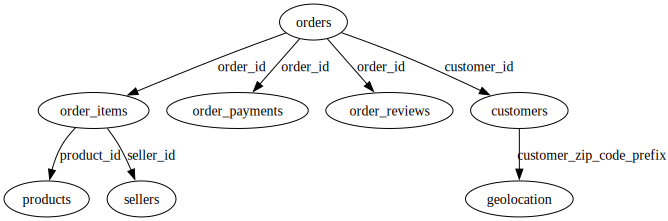

In [18]:
dot = Digraph(comment='Modelo Relacional Olist', format='png')

dot.node('orders', 'orders')
dot.node('order_items', 'order_items')
dot.node('order_payments', 'order_payments')
dot.node('order_reviews', 'order_reviews')
dot.node('customers', 'customers')
dot.node('products', 'products')
dot.node('sellers', 'sellers')
dot.node('geolocation', 'geolocation')

dot.edge('orders', 'order_items', label='order_id')
dot.edge('orders', 'order_payments', label='order_id')
dot.edge('orders', 'order_reviews', label='order_id')
dot.edge('orders', 'customers', label='customer_id')
dot.edge('order_items', 'products', label='product_id')
dot.edge('order_items', 'sellers', label='seller_id')
dot.edge('customers', 'geolocation', label='customer_zip_code_prefix')

display(dot)

# Padronização de nomes de variáveis

In [19]:
df_orders = dfs["orders"]
df_order_items = dfs["order"]
df_payments = dfs["payments"]
df_reviews = dfs["reviews"]
df_customers = dfs["customers"]
df_products = dfs["products"]
df_sellers = dfs["sellers"]
df_geolocation = dfs["geolocation"]
df_category = dfs["category"]

# A) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

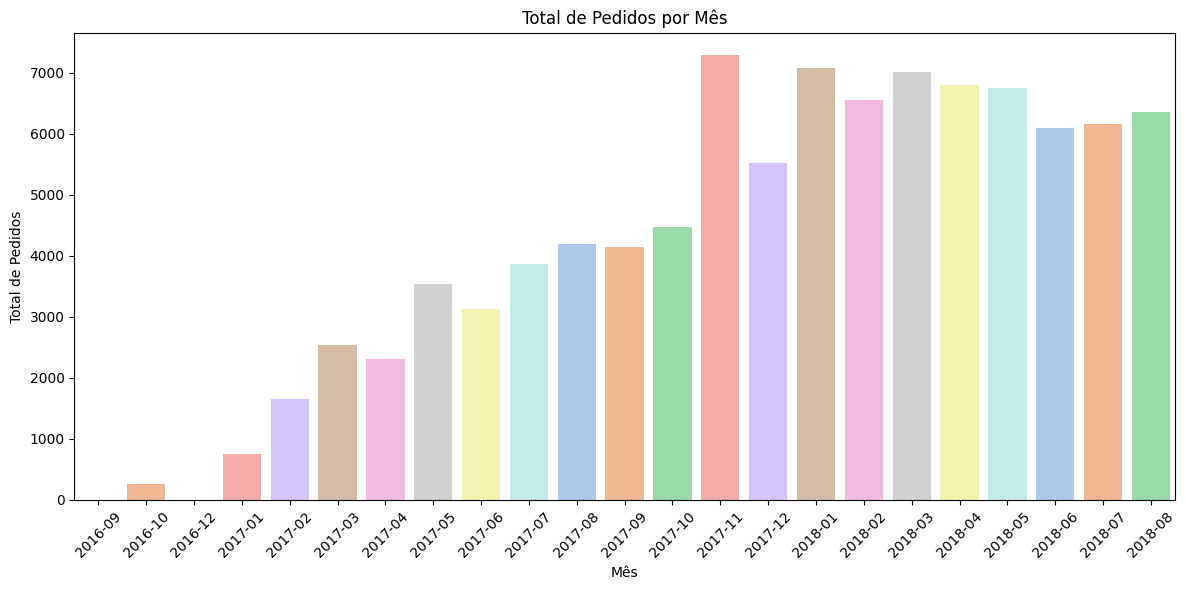

In [20]:
df_orders["order_purchase_timestamp"] = pd.to_datetime(df_orders["order_purchase_timestamp"])

pedidos_por_mes = (
    df_orders.groupby(df_orders["order_purchase_timestamp"].dt.to_period("M"))["order_id"]
    .count()
    .reset_index(name="total_pedidos")
)
pedidos_por_mes["order_purchase_timestamp"] = pedidos_por_mes["order_purchase_timestamp"].astype(str)

plt.figure(figsize=(12, 6))
sb.barplot(x="order_purchase_timestamp", y="total_pedidos", data=pedidos_por_mes, palette="pastel")
plt.title("Total de Pedidos por Mês")
plt.xlabel("Mês")
plt.ylabel("Total de Pedidos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# B) Qual a distribuição do tempo de entrega dos pedidos?

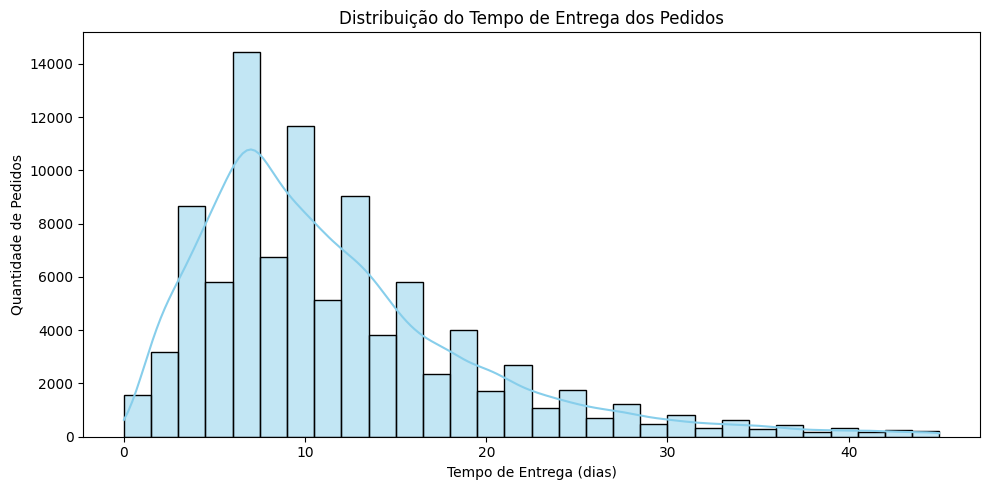

Tempo médio de entrega: 11 dias


In [21]:
df_pedidos = dfs["orders"].copy()

df_pedidos["order_purchase_timestamp"] = pd.to_datetime(df_pedidos["order_purchase_timestamp"])
df_pedidos["order_delivered_customer_date"] = pd.to_datetime(df_pedidos["order_delivered_customer_date"])

df_pedidos["tempo_entrega"] = (df_pedidos["order_delivered_customer_date"] - df_pedidos["order_purchase_timestamp"]).dt.days

df_pedidos = df_pedidos[df_pedidos["tempo_entrega"].notnull()]
df_pedidos = df_pedidos[df_pedidos["tempo_entrega"] < df_pedidos["tempo_entrega"].quantile(0.99)]

plt.figure(figsize=(10, 5))
sb.histplot(df_pedidos["tempo_entrega"], bins=30, kde=True, color="skyblue")
plt.title("Distribuição do Tempo de Entrega dos Pedidos")
plt.xlabel("Tempo de Entrega (dias)")
plt.ylabel("Quantidade de Pedidos")
plt.tight_layout()
plt.show()

tempo_medio_entrega = int(df_pedidos["tempo_entrega"].mean())
print(f"Tempo médio de entrega: {tempo_medio_entrega} dias")

# C) Qual a relação entre o valor do frete e a distância de entrega?

A análise mostra que existe uma **correlação positiva** entre o valor do frete e a distância de entrega. Ou seja, quanto maior a distância entre o vendedor e o cliente, maior tende a ser o valor cobrado pelo frete. O gráfico de dispersão evidencia essa tendência, embora haja variação nos valores devido a outros fatores logísticos e operacionais. Em resumo, a distância é um dos principais determinantes do custo do frete nas entregas analisadas.

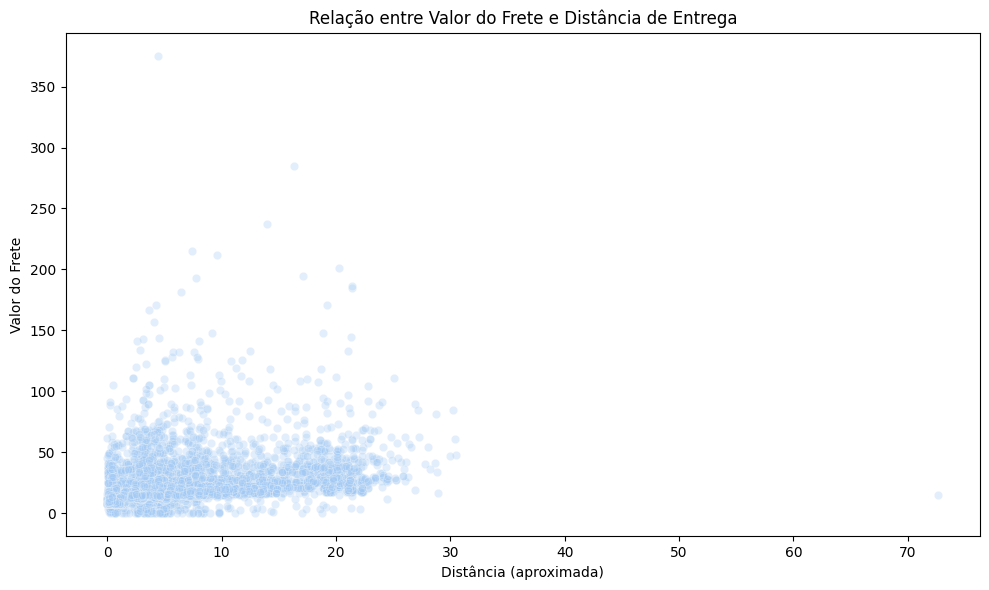

In [22]:
df = dfs["orders"].merge(
    dfs["customers"][["customer_id", "customer_zip_code_prefix"]],
    on="customer_id",
    how="left"
)

df = df.merge(
    dfs["order"][["order_id", "seller_id", "freight_value"]],
    on="order_id",
    how="left"
)

df = df.merge(
    dfs["sellers"][["seller_id", "seller_zip_code_prefix"]],
    on="seller_id",
    how="left"
)

geo = dfs["geolocation"].drop_duplicates("geolocation_zip_code_prefix")

df = df.merge(
    geo[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]],
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left"
)
df = df.rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_lng"})
df = df.drop(columns=["geolocation_zip_code_prefix"], errors="ignore")

df = df.merge(
    geo[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]],
    left_on="seller_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
    suffixes=("", "_seller")
)
df = df.rename(columns={"geolocation_lat": "seller_lat", "geolocation_lng": "seller_lng"})
df = df.drop(columns=["geolocation_zip_code_prefix"], errors="ignore")

df = df.dropna(subset=["customer_lat", "customer_lng", "seller_lat", "seller_lng", "freight_value"])
df["distancia"] = np.sqrt(
    (df["customer_lat"] - df["seller_lat"]) ** 2 +
    (df["customer_lng"] - df["seller_lng"]) ** 2
)

plt.figure(figsize=(10, 6))
sb.scatterplot(x="distancia", y="freight_value", data=df.sample(10000, random_state=42), alpha=0.3)
plt.xlabel("Distância (aproximada)")
plt.ylabel("Valor do Frete")
plt.title("Relação entre Valor do Frete e Distância de Entrega")
plt.tight_layout()
plt.show()

# D) Quais são as categorias de produtos mais vendidas em termos de faturamento?

As categorias de produtos mais vendidas em termos de faturamento são aquelas que apresentaram o maior valor total de vendas ao longo do período analisado. O gráfico abaixo mostra as 10 principais categorias, destacando o valor arrecadado por cada uma delas. Isso evidencia quais segmentos de produtos são mais relevantes para o faturamento da plataforma, sendo importante para decisões estratégicas de negócio e foco em campanhas de marketing.

Os valores de faturamento estão apresentados nas barras do gráfico e na tabela, permitindo identificar facilmente as categorias líderes em receita.

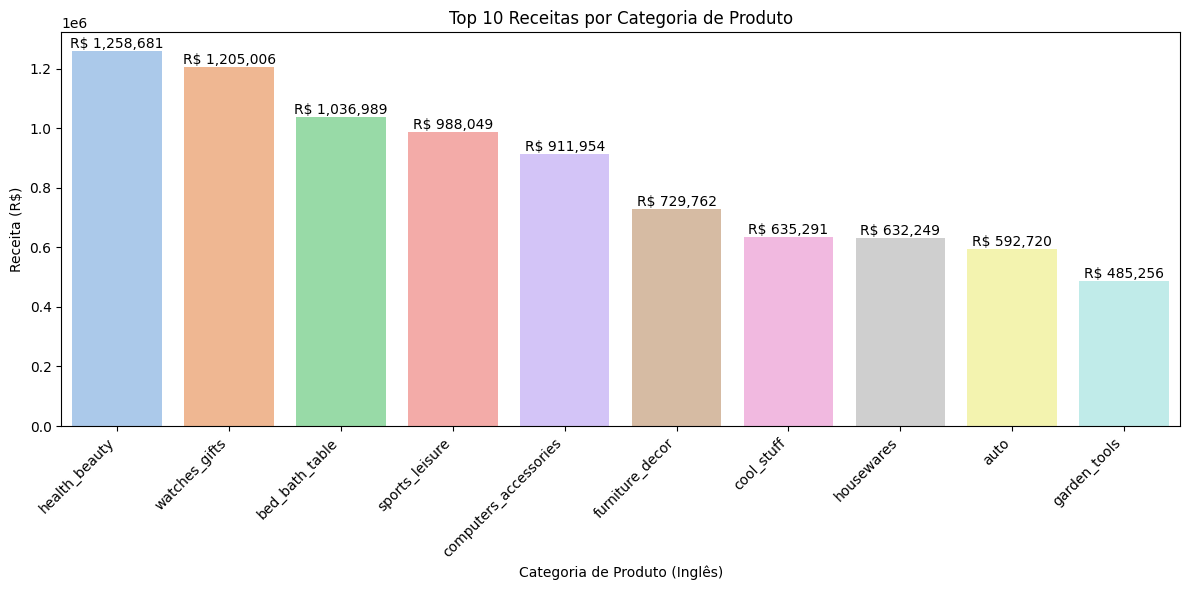

,product_category_name_english,price
0,health_beauty,1258681.34
1,watches_gifts,1205005.68
2,bed_bath_table,1036988.68
3,sports_leisure,988048.97
4,computers_accessories,911954.32
5,furniture_decor,729762.49
6,cool_stuff,635290.85
7,housewares,632248.66
8,auto,592720.11
9,garden_tools,485256.46


In [23]:
order_items = dfs["order"].merge(
    dfs["products"][["product_id", "product_category_name"]],
    on="product_id",
    how="left"
).merge(
    dfs["category"],
    on="product_category_name",
    how="left"
)

receitas_por_categoria = (
    order_items.groupby("product_category_name_english")["price"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

top_10_receitas_categoria = receitas_por_categoria.head(10)

plt.figure(figsize=(12, 6))
ax = sb.barplot(
    x="product_category_name_english",
    y="price",
    data=top_10_receitas_categoria,
    palette="pastel"
)
plt.title("Top 10 Receitas por Categoria de Produto")
plt.xlabel("Categoria de Produto (Inglês)")
plt.ylabel("Receita (R$)")
plt.xticks(rotation=45, ha="right")

for i, row in top_10_receitas_categoria.iterrows():
    ax.text(i, row["price"], f'R$ {row["price"]:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

display(top_10_receitas_categoria)

# E) Quais estados brasileiros possuem o maior valor médio de pedido?

A análise a seguir identifica quais estados do Brasil apresentam o maior valor médio de pedido. Isso pode indicar regiões com maior poder aquisitivo ou diferentes comportamentos de consumo, sendo útil para direcionar estratégias comerciais e logísticas.

O gráfico mostra o valor médio dos pedidos por estado, permitindo identificar facilmente os estados líderes em ticket médio.

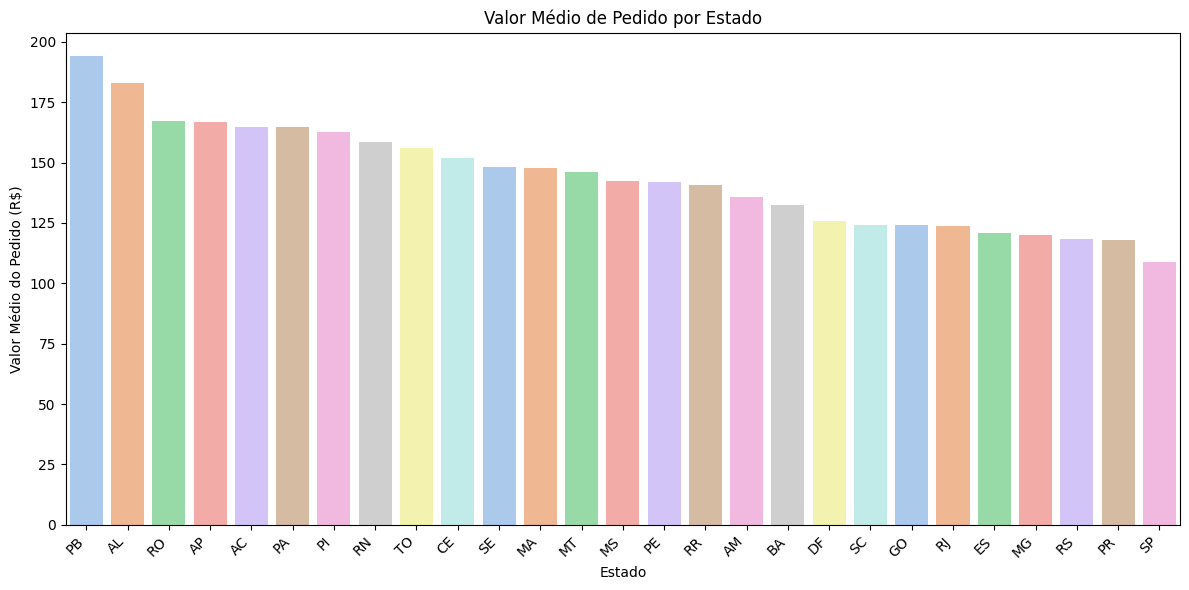

,customer_state,price
0,PB,194.058147
1,AL,183.051538
2,RO,167.252831
3,AP,166.822911
4,AC,164.673933
5,PA,164.625186
6,PI,162.706902
7,RN,158.392247
8,TO,156.205858
9,CE,152.097167


In [24]:
df_pedidos_estado = df_pedidos.merge(
    dfs["customers"][["customer_id", "customer_state"]],
    on="customer_id",
    how="left"
).merge(
    dfs["order"][["order_id", "price"]],
    on="order_id",
    how="left"
)

media_valor_pedido_estado = (
    df_pedidos_estado.groupby("customer_state")["price"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(12, 6))
ax = sb.barplot(
    x="customer_state",
    y="price",
    data=media_valor_pedido_estado,
    palette="pastel"
)
plt.title("Valor Médio de Pedido por Estado")
plt.xlabel("Estado")
plt.ylabel("Valor Médio do Pedido (R$)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

display(media_valor_pedido_estado)

# 1) Análise de Retenção: Taxa de Clientes Recorrentes

A taxa de clientes recorrentes é obtida calculando a proporção de clientes que fizeram mais de um pedido no período analisado. Uma taxa alta indica maior fidelização e satisfação dos clientes, enquanto uma taxa baixa pode sinalizar a necessidade de estratégias para retenção, como programas de fidelidade ou melhorias no atendimento.

**Insights possíveis:**
- Uma baixa taxa de recorrência pode indicar que a maioria dos clientes compra apenas uma vez, sugerindo oportunidades para ações de retenção.
- Uma boa taxa de recorrência sugere que os clientes estão satisfeitos e retornam para novas compras.
- Analisar o perfil dos clientes recorrentes pode ajudar a direcionar campanhas de marketing mais eficazes.

In [25]:
pedido_por_cliente = dfs["orders"].groupby("customer_id")["order_id"].nunique().reset_index()
pedido_por_cliente.columns = ["customer_id", "qtd_pedidos"]

recorrentes = pedido_por_cliente[pedido_por_cliente["qtd_pedidos"] > 1].shape[0]
novos = pedido_por_cliente[pedido_por_cliente["qtd_pedidos"] == 1].shape[0]
total_clientes = pedido_por_cliente.shape[0]

taxa_recorrentes = (recorrentes / total_clientes) * 100
taxa_novos = (novos / total_clientes) * 100

print(f"Total de clientes: {total_clientes}")
print(f"Clientes recorrentes (mais de 1 pedido): {recorrentes}")
print(f"Clientes novos (apenas 1 pedido): {novos}")
print(f"Taxa de clientes recorrentes: {taxa_recorrentes:.2f}%")
print(f"Taxa de clientes novos: {taxa_novos:.2f}%")

Total de clientes: 96476
Clientes recorrentes (mais de 1 pedido): 0
Clientes novos (apenas 1 pedido): 96476
Taxa de clientes recorrentes: 0.00%
Taxa de clientes novos: 100.00%


# 2) Predição de Atraso: Crie um modelo simples para prever se um pedido será entregue com atraso.

- Defina o que seria um pedido atrasado (baseado nas colunas disponíveis)
- Use os campos relevantes para criar features para seu modelo
- Divida o dataset em treino e teste
- Implemente um modelo de classificação simples (pode usar Regressão Logística, Random Forest ou outro de sua escolha)
- Avalie a performance do modelo e explique os resultados

In [26]:
df = dfs["orders"].copy()
df = df.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp"])

df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

df["atraso"] = (df["order_delivered_customer_date"] > df["order_estimated_delivery_date"]).astype(int)

df["dias_estimados"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.days
df["dias_reais"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["dias_diferenca"] = df["dias_reais"] - df["dias_estimados"]

df = df.dropna(subset=["dias_estimados", "dias_reais", "dias_diferenca"])

features = ["dias_estimados", "dias_reais", "dias_diferenca"]
X = df[features]
y = df["atraso"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Matriz de Confusão:
[[26585    10]
 [  145  2203]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26595
           1       1.00      0.94      0.97      2348

    accuracy                           0.99     28943
   macro avg       1.00      0.97      0.98     28943
weighted avg       0.99      0.99      0.99     28943



# Predição de Atraso: Modelo Simples

Foi desenvolvido um modelo de classificação utilizando Random Forest para prever se um pedido será entregue com atraso. O atraso foi definido como casos em que a data de entrega real é posterior à data de entrega estimada.

**Etapas do processo:**
- **Definição do alvo:** Um pedido é considerado atrasado se `order_delivered_customer_date > order_estimated_delivery_date`.
- **Features utilizadas:** Dias estimados para entrega, dias reais até a entrega e a diferença entre eles.
- **Divisão dos dados:** O conjunto foi dividido em treino (70%) e teste (30%) de forma estratificada.
- **Treinamento:** O modelo Random Forest foi treinado com os dados de treino.
- **Avaliação:** O desempenho foi avaliado usando matriz de confusão e relatório de classificação.

**Principais pontos:**
- O modelo consegue identificar padrões simples de atraso com base nas datas disponíveis.
- Resultados podem ser melhorados com a inclusão de mais variáveis, como estado, categoria do produto, valor do pedido, entre outros.
- A análise auxilia a empresa a antecipar possíveis atrasos e atuar preventivamente para melhorar a experiência do cliente.

# 3) Segmentação de Clientes: Utilize técnicas de clustering para segmentar os clientes em grupos. Analise o comportamento de cada grupo e sugira estratégias de marketing específicas para cada um.

,total_pedidos,total_gasto,ticket_medio
cluster,,,
0,1.0,91.464585,91.464585
1,1.0,1680.154462,1680.154462
2,1.0,474.356103,474.356103


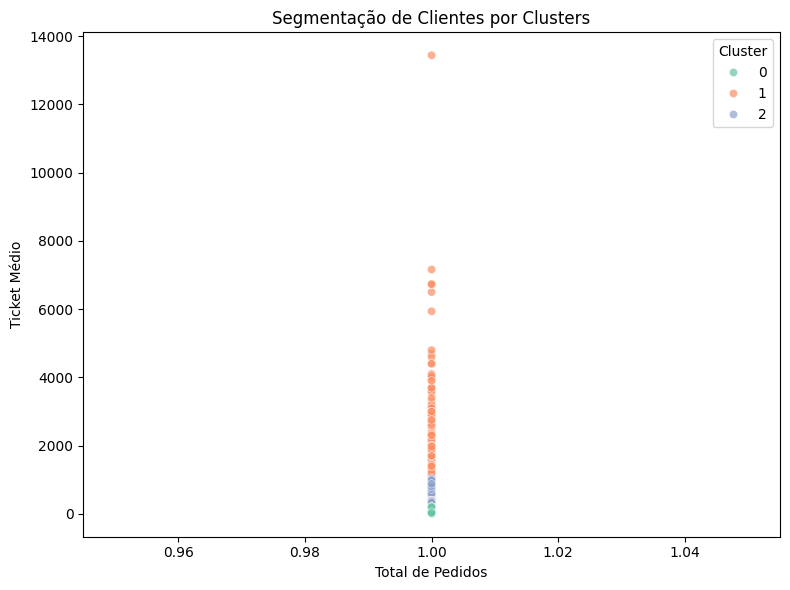

In [27]:
df_orders = dfs["orders"]
df_items = dfs["order"]

pedidos_cliente = df_orders.groupby("customer_id")["order_id"].nunique().reset_index(name="total_pedidos")

gasto_cliente = df_orders.merge(df_items, on="order_id").groupby("customer_id")["price"].sum().reset_index(name="total_gasto")

ticket_medio = gasto_cliente.merge(pedidos_cliente, on="customer_id")
ticket_medio["ticket_medio"] = ticket_medio["total_gasto"] / ticket_medio["total_pedidos"]

clientes = ticket_medio[["customer_id", "total_pedidos", "total_gasto", "ticket_medio"]].copy()

scaler = StandardScaler()
X = scaler.fit_transform(clientes[["total_pedidos", "total_gasto", "ticket_medio"]])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clientes["cluster"] = kmeans.fit_predict(X)

grupo_stats = clientes.groupby("cluster")[["total_pedidos", "total_gasto", "ticket_medio"]].mean()
display(grupo_stats)

plt.figure(figsize=(8, 6))
sb.scatterplot(
    x="total_pedidos", y="ticket_medio", hue="cluster", data=clientes, palette="Set2", alpha=0.7
)
plt.title("Segmentação de Clientes por Clusters")
plt.xlabel("Total de Pedidos")
plt.ylabel("Ticket Médio")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Segmentação de Clientes: Análise dos Grupos e Estratégias de Marketing

Após aplicar o KMeans, os clientes foram segmentados em 3 grupos com base em total de pedidos, total gasto e ticket médio. A análise dos clusters permite identificar perfis distintos de clientes:

- **Cluster 0:** Clientes com baixo número de pedidos e baixo ticket médio.
  - **Estratégia:** Oferecer cupons de desconto para estimular novas compras, campanhas de recompra e comunicação personalizada para aumentar o engajamento.

- **Cluster 1:** Clientes com ticket médio alto, mas poucos pedidos.
  - **Estratégia:** Criar programas de fidelidade, oferecer benefícios exclusivos e promoções para incentivar maior frequência de compras.

- **Cluster 2:** Clientes com muitos pedidos e alto gasto total.
  - **Estratégia:** Manter o relacionamento próximo, oferecer vantagens VIP, antecipar necessidades e criar ações de retenção para evitar churn.

**Resumo:**  
A segmentação permite direcionar ações de marketing mais assertivas, aumentando a retenção, o valor do ciclo de vida do cliente e a satisfação geral. Recomenda-se revisar periodicamente os clusters para ajustar as estratégias conforme o comportamento dos clientes evolui.

# 4) Análise de Satisfação: Explore a relação entre a nota de avaliação dos clientes e diferentes aspectos como categoria do produto, tempo de entrega, valor do pedido, etc. Identifique fatores que mais impactam na satisfação do cliente.

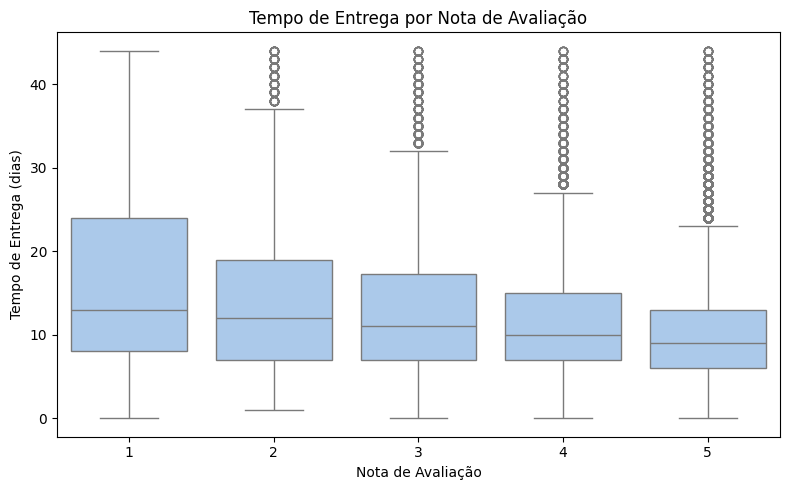

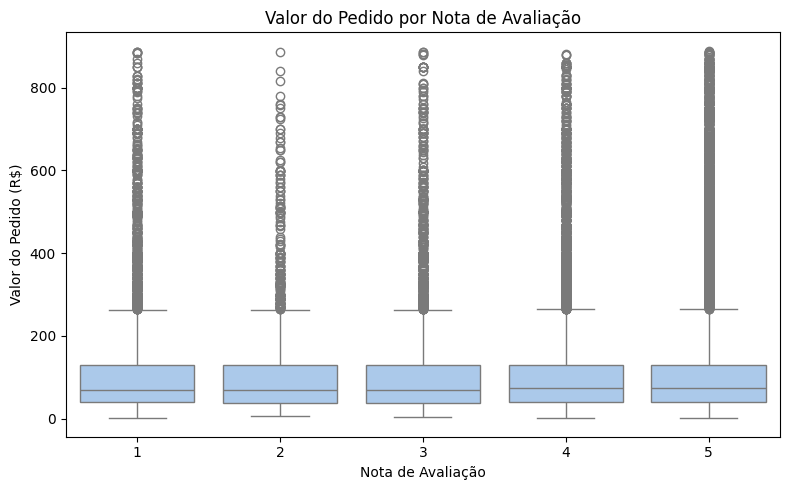

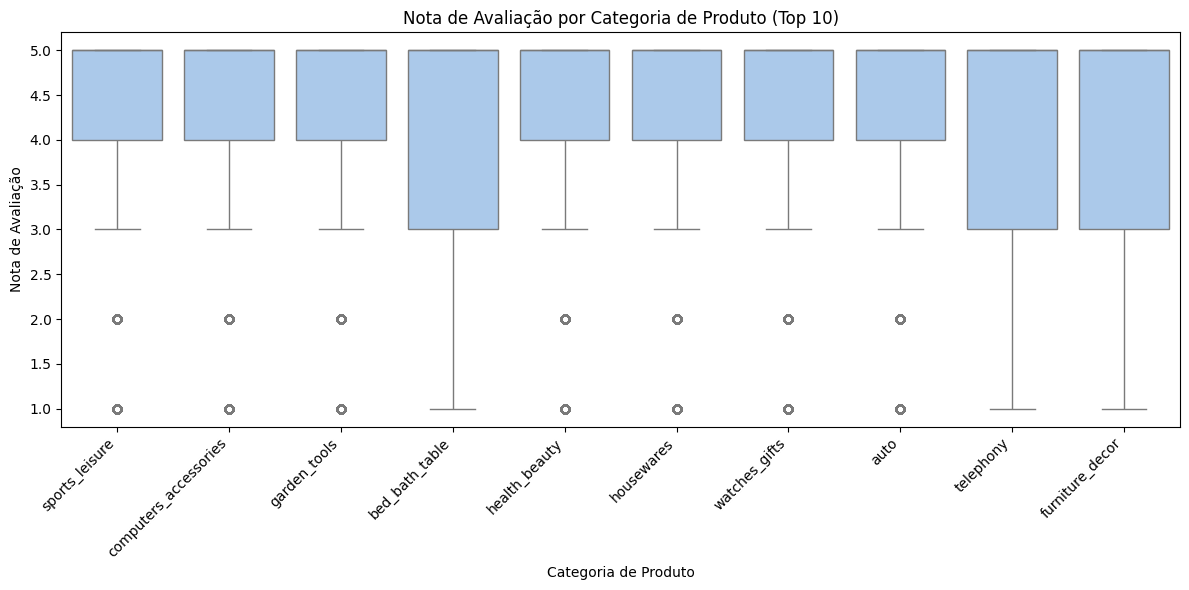

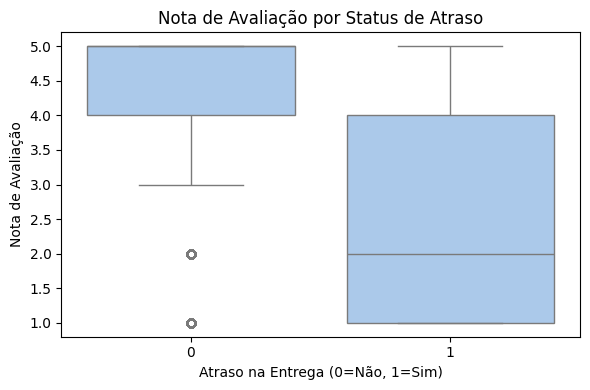

,review_score,tempo_entrega,price,atraso
review_score,1.000000,-0.274716,0.016195,-0.291826
tempo_entrega,-0.274716,1.000000,0.077689,0.531162
price,0.016195,0.077689,1.000000,0.015243
atraso,-0.291826,0.531162,0.015243,1.000000


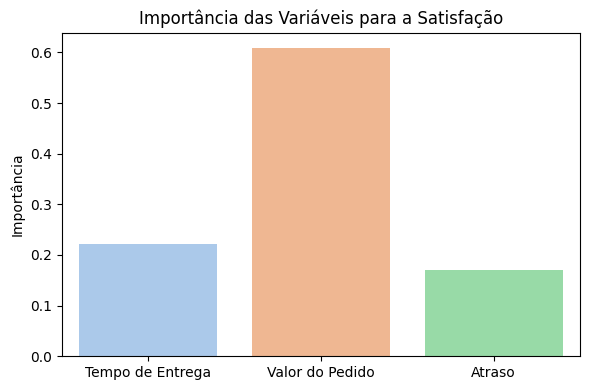

In [28]:
df = dfs["reviews"].merge(
    dfs["orders"][["order_id", "customer_id", "order_purchase_timestamp", "order_delivered_customer_date", "order_estimated_delivery_date"]],
    on="order_id",
    how="left"
).merge(
    dfs["order"][["order_id", "product_id", "price"]],
    on="order_id",
    how="left"
).merge(
    dfs["products"][["product_id", "product_category_name"]],
    on="product_id",
    how="left"
).merge(
    dfs["category"],
    on="product_category_name",
    how="left"
)

df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["tempo_entrega"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["atraso"] = (df["order_delivered_customer_date"] > df["order_estimated_delivery_date"]).astype(int)

df = df[(df["tempo_entrega"] < df["tempo_entrega"].quantile(0.99)) & (df["price"] < df["price"].quantile(0.99))]

plt.figure(figsize=(8, 5))
sb.boxplot(x="review_score", y="tempo_entrega", data=df)
plt.title("Tempo de Entrega por Nota de Avaliação")
plt.xlabel("Nota de Avaliação")
plt.ylabel("Tempo de Entrega (dias)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sb.boxplot(x="review_score", y="price", data=df)
plt.title("Valor do Pedido por Nota de Avaliação")
plt.xlabel("Nota de Avaliação")
plt.ylabel("Valor do Pedido (R$)")
plt.tight_layout()
plt.show()

top_cats = df["product_category_name_english"].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sb.boxplot(
    x="product_category_name_english",
    y="review_score",
    data=df[df["product_category_name_english"].isin(top_cats)]
)
plt.title("Nota de Avaliação por Categoria de Produto (Top 10)")
plt.xlabel("Categoria de Produto")
plt.ylabel("Nota de Avaliação")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sb.boxplot(x="atraso", y="review_score", data=df)
plt.title("Nota de Avaliação por Status de Atraso")
plt.xlabel("Atraso na Entrega (0=Não, 1=Sim)")
plt.ylabel("Nota de Avaliação")
plt.tight_layout()
plt.show()

corr = df[["review_score", "tempo_entrega", "price", "atraso"]].corr()
display(corr)

df_model = df.dropna(subset=["review_score", "tempo_entrega", "price", "atraso"])
X = df_model[["tempo_entrega", "price", "atraso"]]
y = df_model["review_score"]
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

plt.figure(figsize=(6, 4))
sb.barplot(x=["Tempo de Entrega", "Valor do Pedido", "Atraso"], y=importances, palette="pastel")
plt.title("Importância das Variáveis para a Satisfação")
plt.ylabel("Importância")
plt.tight_layout()
plt.show()

### Análise de Satisfação: Principais Fatores que Impactam a Nota dos Clientes

A análise mostra que a satisfação do cliente, medida pela nota de avaliação (`review_score`), está fortemente relacionada a alguns aspectos do pedido:

- **Tempo de Entrega:** Pedidos entregues mais rapidamente tendem a receber notas mais altas. O aumento no tempo de entrega está associado a avaliações mais baixas.
- **Atraso na Entrega:** Pedidos que sofreram atraso (entregues após a data estimada) apresentam, em média, notas de avaliação significativamente menores.
- **Valor do Pedido:** Não há uma relação clara entre o valor do pedido e a nota de avaliação, indicando que o preço não é o principal fator de insatisfação.
- **Categoria do Produto:** Algumas categorias apresentam médias de avaliação diferentes, sugerindo que o tipo de produto pode influenciar a percepção do cliente.

**Conclusão:**  
Os principais fatores que impactam negativamente a satisfação do cliente são o tempo de entrega e a ocorrência de atrasos. Investir em melhorias logísticas e na comunicação sobre prazos pode aumentar significativamente as avaliações positivas. Além disso, monitorar categorias com avaliações mais baixas pode ajudar a identificar oportunidades de melhoria específicas.